In [1]:
import pandas as pd
from sklearn.datasets import make_blobs

n_samples = [1000, 1000, 1000] 
n_features = 4 
n_classes = 3  
random_state = 42

X, y = make_blobs(n_samples=n_samples, n_features=n_features, random_state=random_state)
df = pd.DataFrame(X, columns=[f'feature_{i+1}' for i in range(n_features)])
df['class'] = y

def print_cls_shape(df):
    for cls in range(n_classes):
        num_cls = df[df['class'] == cls].shape[0]
        print(f'Num elements of class {cls}: {num_cls}')

print_cls_shape(df)

Num elements of class 0: 1000
Num elements of class 1: 1000
Num elements of class 2: 1000


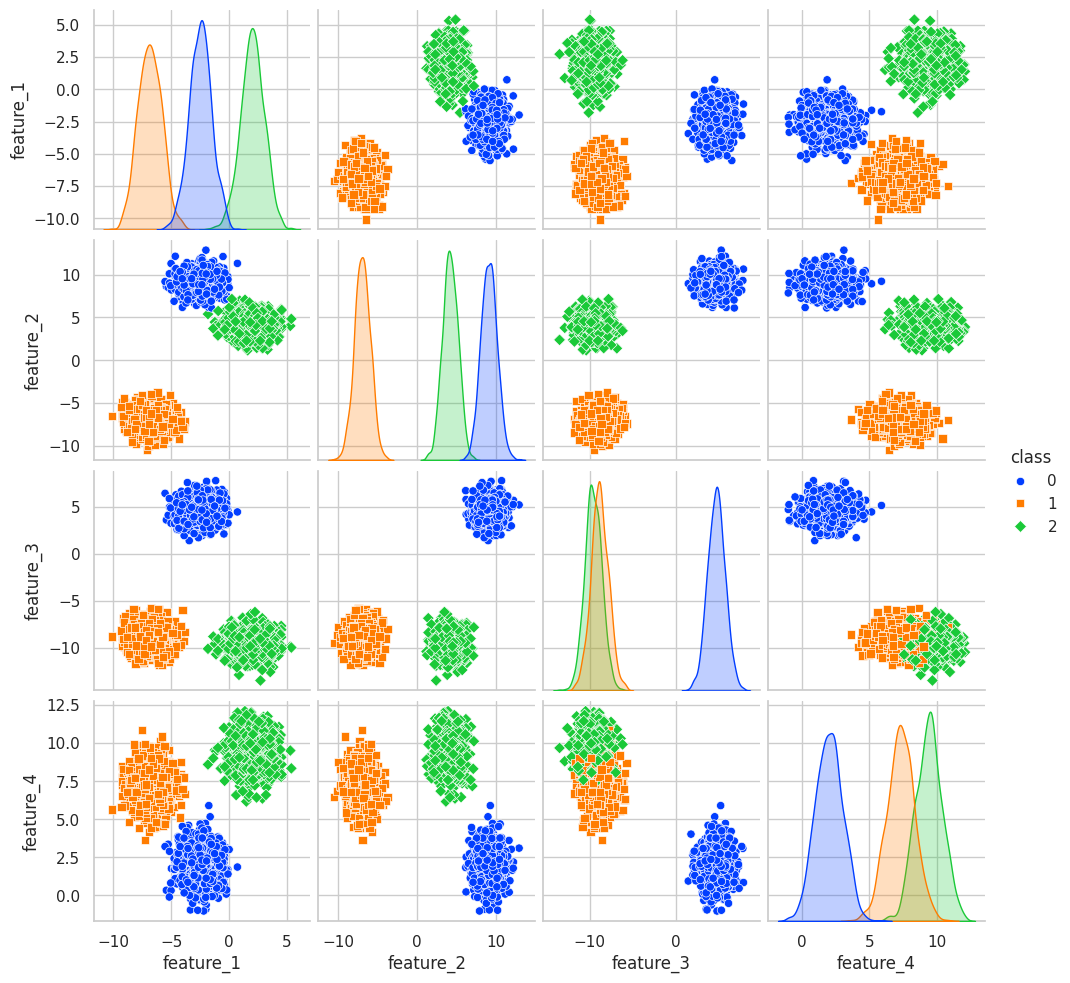

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

pair_plot = sns.pairplot(df, hue='class', palette='bright', markers=["o", "s", "D"], diag_kind='kde')

plt.show()

In [3]:
def duplicate_class(df, cls_name, n):
    if n <= 1: return df
    cls = df[df['class'] == cls_name]
    df_cls = pd.concat([cls] * (n - 1), ignore_index=True)
    df = pd.concat([df, df_cls], ignore_index=True)
    return df

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

def draw_decision_boundary(ax, model, df, cls_name1, cls_name2, feature1='feature_1', feature2='feature_2', title='LDA decision boundary'):
    df_filtered = df[df['class'].isin([cls_name1, cls_name2])] 
    X = df_filtered[[feature1, feature2]] 
    y = df_filtered['class']

    model.fit(X, y)

    w = model.coef_[0]
    b = model.intercept_[0]

    x_min, x_max = df_filtered[feature1].min() - 1, df_filtered[feature1].max() + 1
    y_min, y_max = df_filtered[feature2].min() - 1, df_filtered[feature2].max() + 1

    x_vals = np.array([x_min, x_max])  
    y_vals = -(w[0] / w[1]) * x_vals - (b / w[1])  

    ax.plot(x_vals, y_vals, color='red', linewidth=2)
    
    sns.scatterplot(x=feature1, y=feature2, hue='class', palette='bright', data=df_filtered, s=100, edgecolor='k', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

/tmp/ipykernel_137548/2335050333.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/kirill/analytics/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


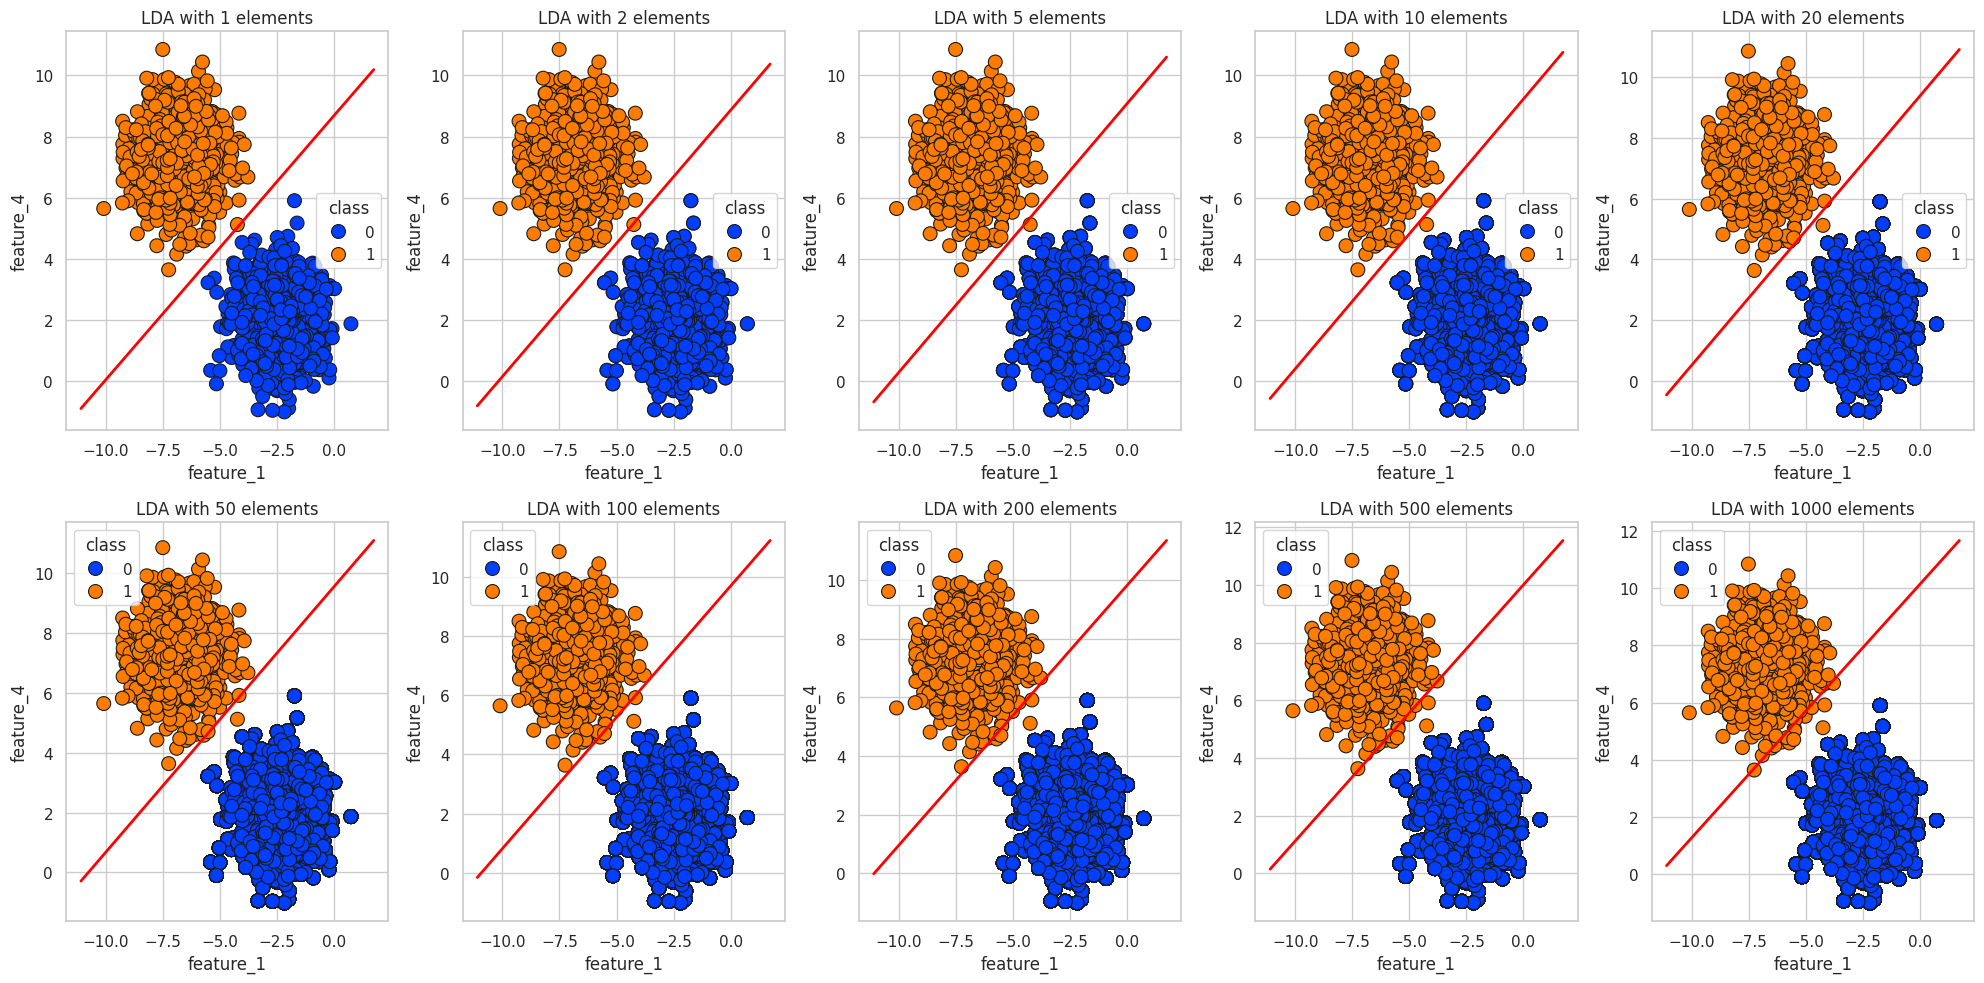

In [4]:
sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, size in enumerate(sizes):
    df_temp = duplicate_class(df, cls_name=0, n=size)
    lda = LDA(n_components=1)
    draw_decision_boundary(axes[i], lda, df_temp, cls_name1=0, cls_name2=1, title=f'LDA with {size} elements', feature1='feature_1', feature2='feature_4')

plt.tight_layout()
plt.show()

/tmp/ipykernel_137548/1040298077.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/kirill/analytics/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


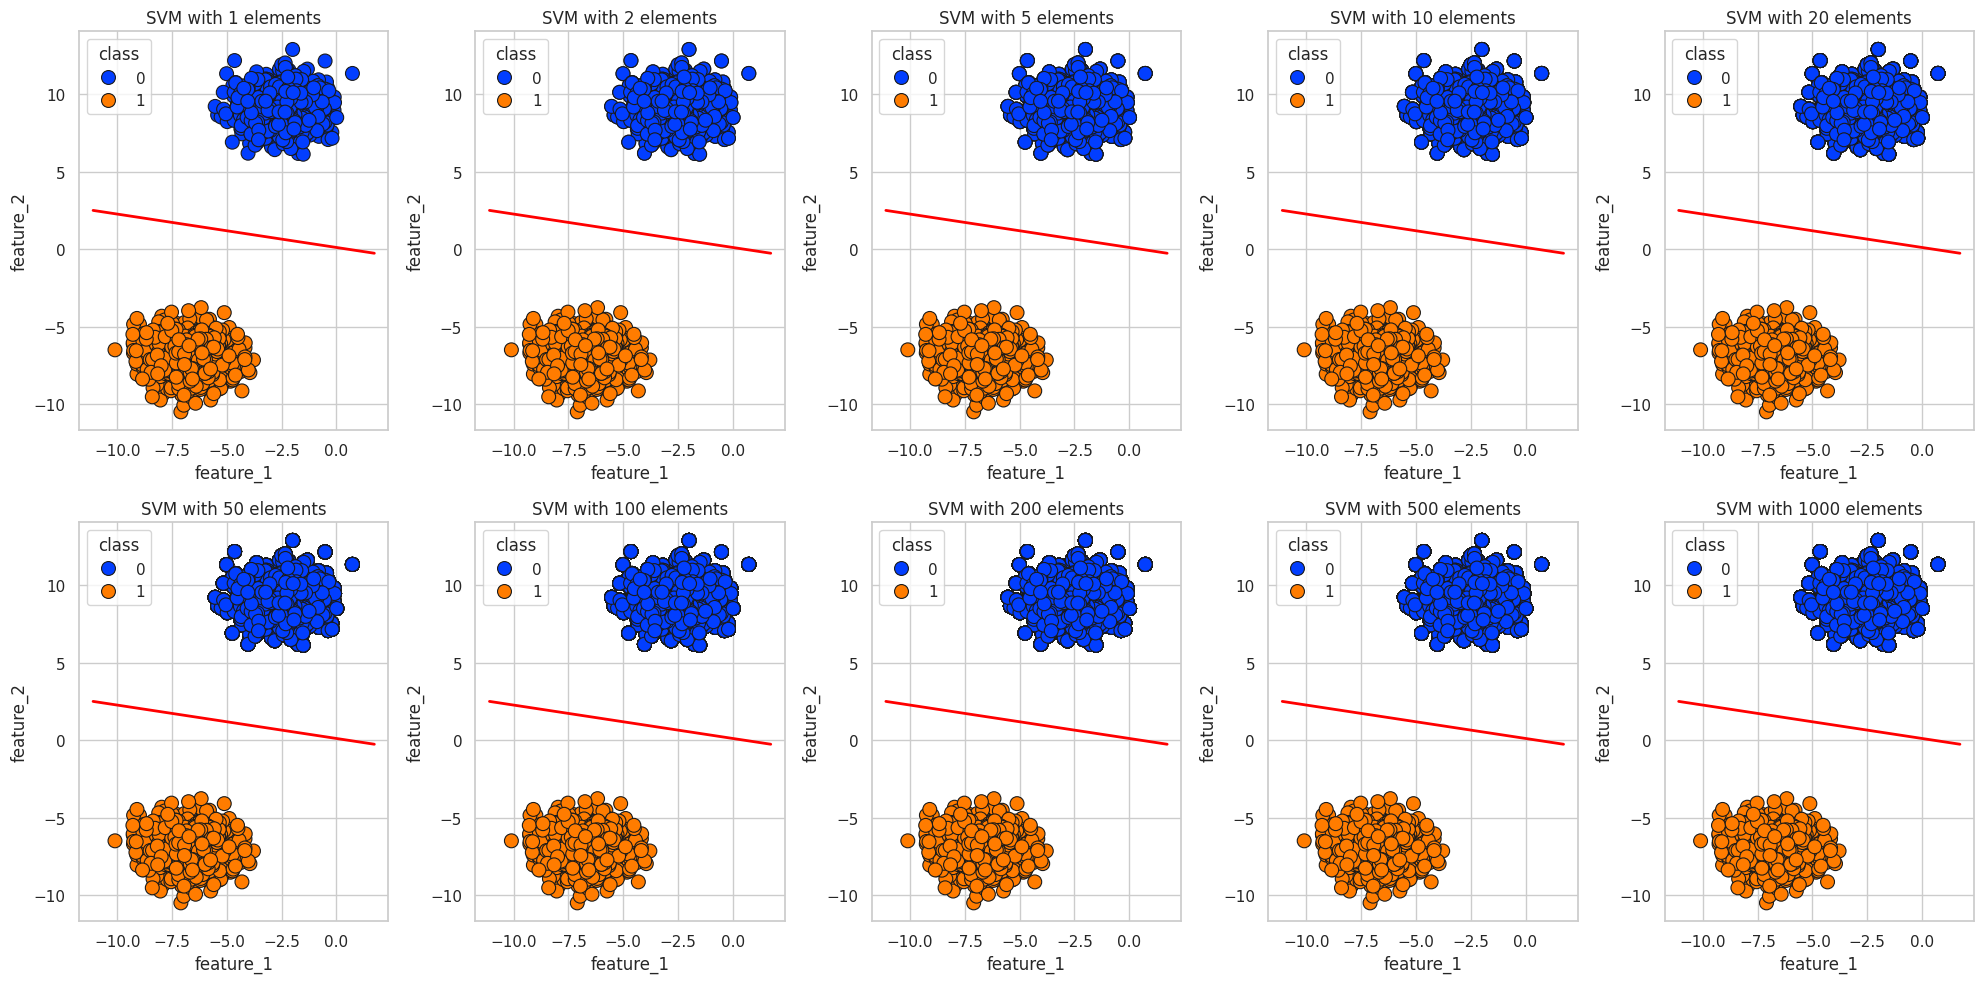

In [5]:
from sklearn.svm import SVC

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

svm = SVC(kernel='linear', C=1.0, random_state=42)

for i, size in enumerate(sizes):
    df_temp = duplicate_class(df, cls_name=0, n=size)
    draw_decision_boundary(axes[i], svm, df_temp, cls_name1=0, cls_name2=1, title=f'SVM with {size} elements')

plt.tight_layout()
plt.show()

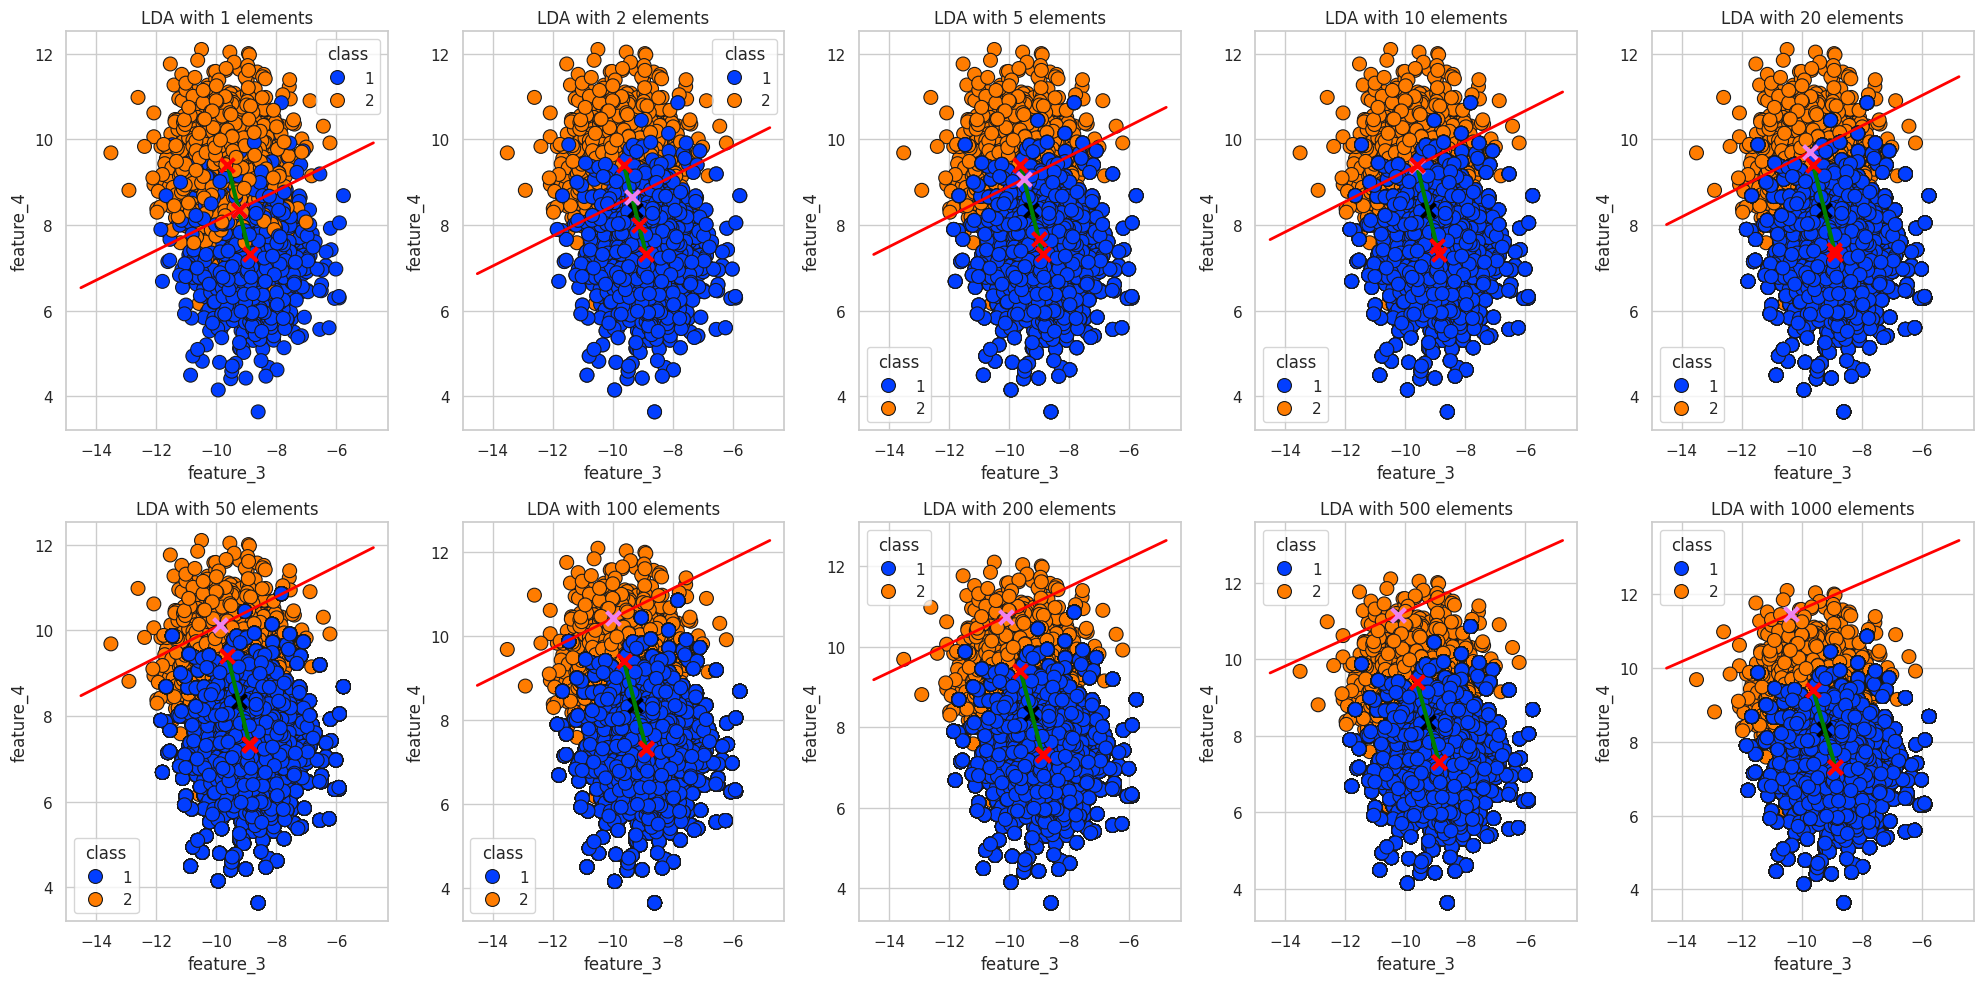

In [57]:
def find_centers(df, cls_name1, cls_name2, class_col='class', feature1='feature_3', feature2='feature_4'):
    df_filtered = df[df[class_col].isin([cls_name1, cls_name2])]
    
    center_class1 = df_filtered[df_filtered[class_col] == cls_name1][[feature1, feature2]].mean().values
    center_class2 = df_filtered[df_filtered[class_col] == cls_name2][[feature1, feature2]].mean().values
    
    overall_center = df_filtered[[feature1, feature2]].mean().values

    return center_class1, center_class2, overall_center


def find_intersection(center_class1, center_class2, w, b):
    x1, y1 = center_class1
    x2, y2 = center_class2
    
    if x2 - x1 != 0:
        m_line = (y2 - y1) / (x2 - x1)  
        c_line = y1 - m_line * x1 
    else:
        m_line = np.inf 
        c_line = x1 

    m_lda = -w[0] / w[1]  
    c_lda = -b / w[1]  

    if m_line != m_lda:  
        x_intersection = (c_lda - c_line) / (m_line - m_lda)
        y_intersection = m_line * x_intersection + c_line
        return (x_intersection, y_intersection)
    
    return 


fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

dots = []

for i, size in enumerate(sizes):
    df_temp = duplicate_class(df, cls_name=1, n=size)
    lda = LDA(n_components=1)
    draw_decision_boundary(axes[i], lda, df_temp, cls_name1=1, cls_name2=2, title=f'LDA with {size} elements', feature1='feature_3', feature2='feature_4')

    center_class1, center_class2, overall_center = find_centers(df_temp, cls_name1=1, cls_name2=2)


    intersection_dot = find_intersection(center_class1, center_class2, lda.coef_[0], lda.intercept_[0])
    axes[i].scatter(*intersection_dot, color='violet', s=100, marker='x', linewidth=3, zorder=10)
    
    axes[i].plot([center_class1[0], center_class2[0]], [center_class1[1], center_class2[1]], color='green', linewidth=3)

    axes[i].scatter(*((center_class1 + center_class2) / 2), color='black', s=100, marker='x', linewidth=3)
    axes[i].scatter(*center_class1, color='red', s=100, marker='x', linewidth=3, zorder=10)
    axes[i].scatter(*center_class2, color='red', s=100, marker='x', linewidth=3, zorder=10)
    axes[i].scatter(*overall_center, color='red', s=100, marker='x', linewidth=3, zorder=10)

    dots.append([center_class1, center_class2, overall_center, ((center_class1 + center_class2) / 2), intersection_dot])

    
plt.tight_layout()
plt.show()

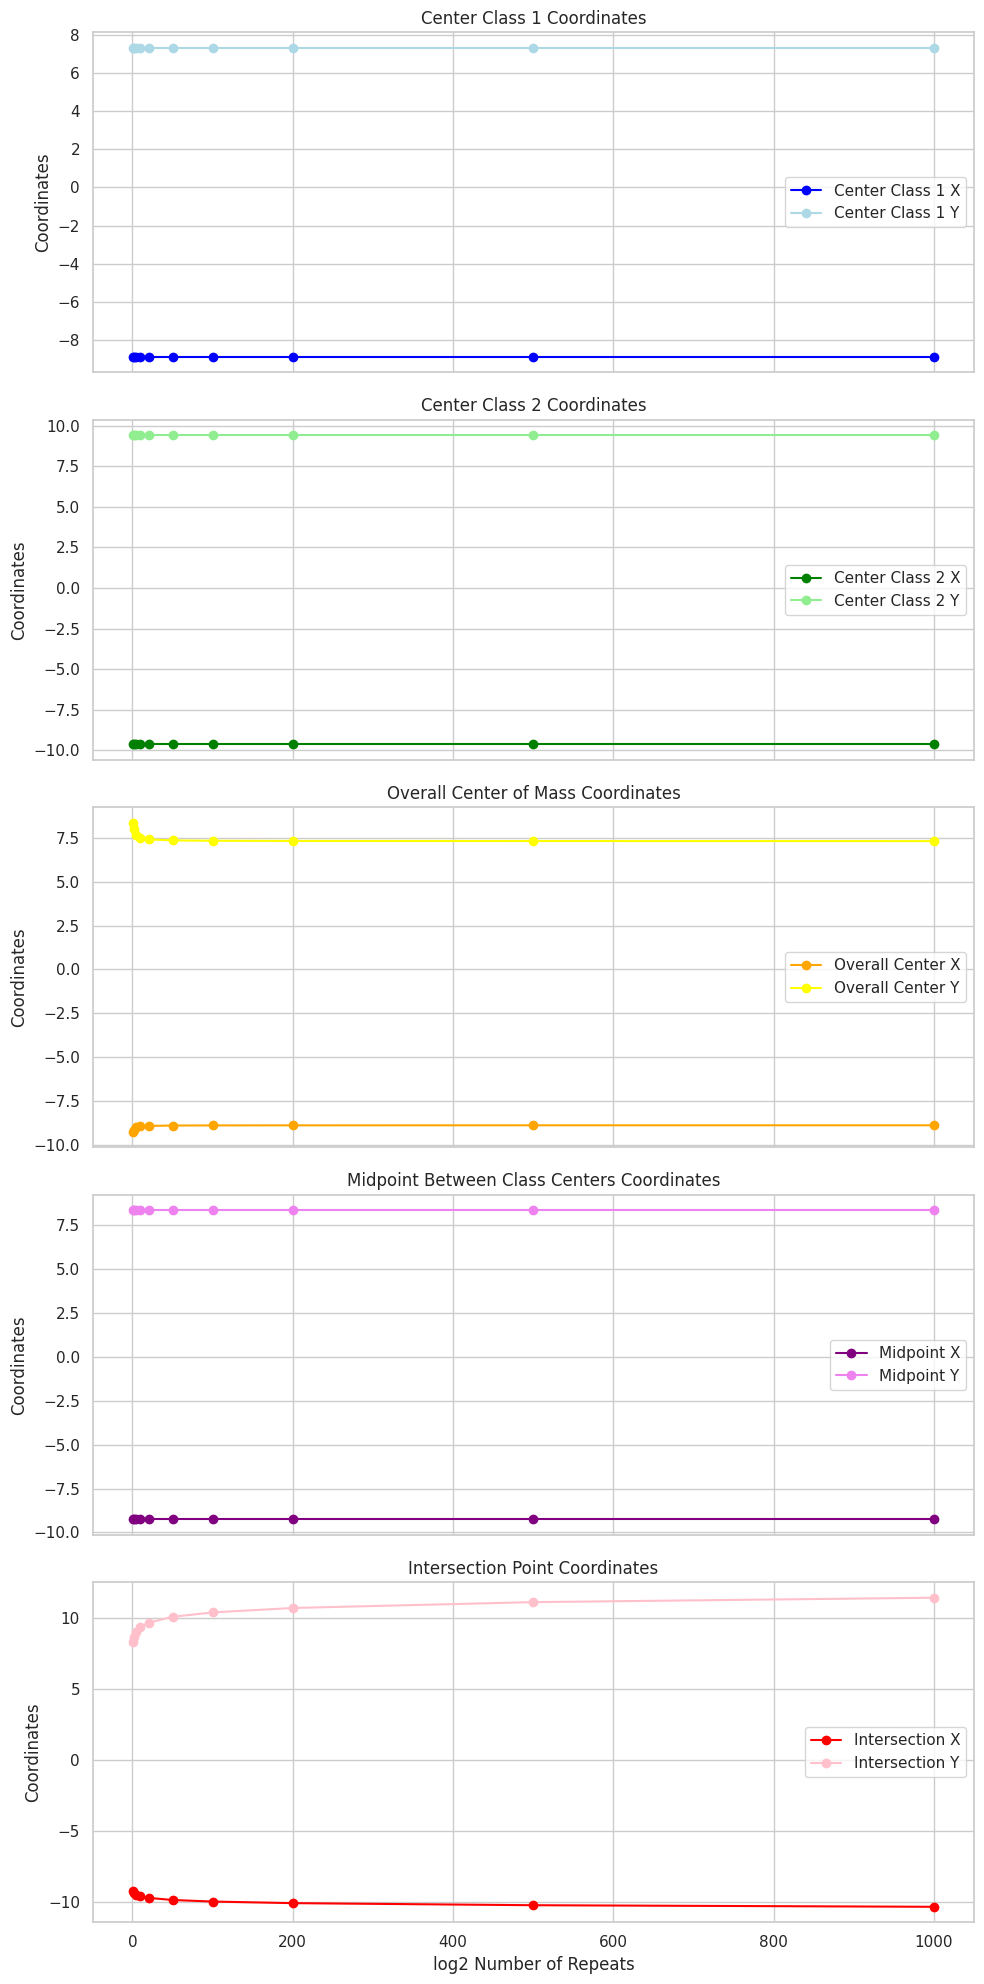

In [58]:
centers_1 = np.array([dot[0] for dot in dots])
centers_2 = np.array([dot[1] for dot in dots]) 
overall_center = np.array([dot[2] for dot in dots]) 
line_center = np.array([dot[3] for dot in dots])
intersection_center = np.array([dot[4] for dot in dots])

fig, axes = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

sizes = np.asarray(sizes)

axes[0].plot(sizes, centers_1[:, 0], marker='o', label='Center Class 1 X', color='blue')
axes[0].plot(sizes, centers_1[:, 1], marker='o', label='Center Class 1 Y', color='lightblue')
axes[0].set_title('Center Class 1 Coordinates')
axes[0].set_ylabel('Coordinates')
axes[0].legend()

axes[1].plot(sizes, centers_2[:, 0], marker='o', label='Center Class 2 X', color='green')
axes[1].plot(sizes, centers_2[:, 1], marker='o', label='Center Class 2 Y', color='lightgreen')
axes[1].set_title('Center Class 2 Coordinates')
axes[1].set_ylabel('Coordinates')
axes[1].legend()

axes[2].plot(sizes, overall_center[:, 0], marker='o', label='Overall Center X', color='orange')
axes[2].plot(sizes, overall_center[:, 1], marker='o', label='Overall Center Y', color='yellow')
axes[2].set_title('Overall Center of Mass Coordinates')
axes[2].set_ylabel('Coordinates')
axes[2].legend()

axes[3].plot(sizes, line_center[:, 0], marker='o', label='Midpoint X', color='purple')
axes[3].plot(sizes, line_center[:, 1], marker='o', label='Midpoint Y', color='violet')
axes[3].set_title('Midpoint Between Class Centers Coordinates')
axes[3].set_ylabel('Coordinates')
axes[3].legend()

axes[4].plot(sizes, intersection_center[:, 0], marker='o', label='Intersection X', color='red')
axes[4].plot(sizes, intersection_center[:, 1], marker='o', label='Intersection Y', color='pink')
axes[4].set_title('Intersection Point Coordinates')
axes[4].set_xlabel('log2 Number of Repeats')
axes[4].set_ylabel('Coordinates')
axes[4].legend()

plt.tight_layout()
plt.show()

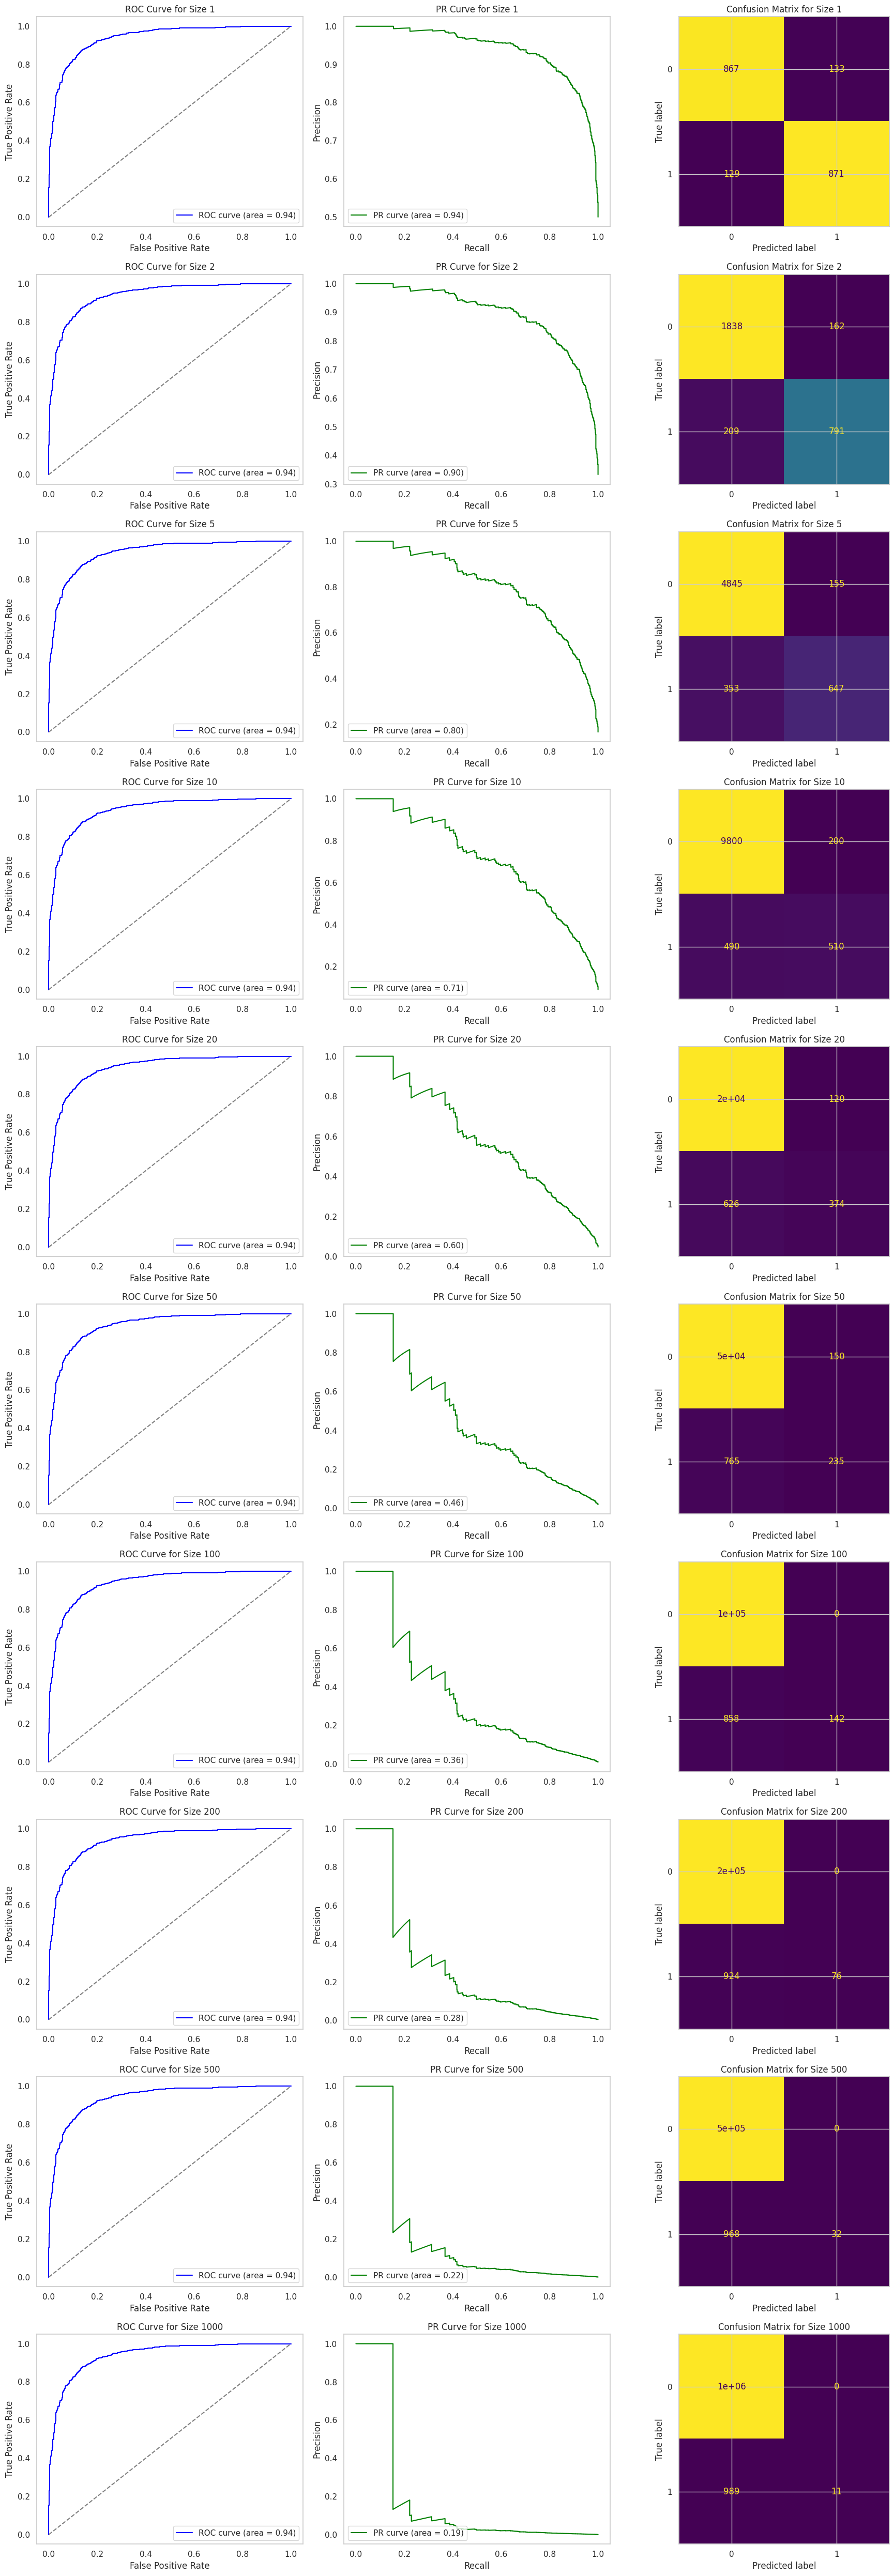

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(len(sizes), 3, figsize=(18, 5 * len(sizes)))
axes = axes.flatten()

results = []

for i, size in enumerate(sizes):
    df_temp = duplicate_class(df, cls_name=1, n=size)
    df_temp = df_temp[df_temp['class'].isin([1, 2])] 
    lda = LDA(n_components=1)

    X = df_temp[['feature_3', 'feature_4']]
    y = df_temp['class']
    y = y.replace(1, 0)
    y = y.replace(2, 1)
    lda.fit(X, y)

    y_scores = lda.predict_proba(X)[:, 1]
    y_pred = lda.predict(X)

    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    axes[i * 3].plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
    axes[i * 3].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i * 3].set_xlabel('False Positive Rate')
    axes[i * 3].set_ylabel('True Positive Rate')
    axes[i * 3].set_title(f'ROC Curve for Size {size}')
    axes[i * 3].legend(loc='lower right')
    axes[i * 3].grid()

    precision, recall, _ = precision_recall_curve(y, y_scores)
    auprc = auc(recall, precision)

    axes[i * 3 + 1].plot(recall, precision, color='green', label='PR curve (area = {:.2f})'.format(auprc))
    axes[i * 3 + 1].set_xlabel('Recall')
    axes[i * 3 + 1].set_ylabel('Precision')
    axes[i * 3 + 1].set_title(f'PR Curve for Size {size}')
    axes[i * 3 + 1].legend(loc='lower left')
    axes[i * 3 + 1].grid()

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i * 3 + 2], colorbar=False)
    axes[i * 3 + 2].set_title(f'Confusion Matrix for Size {size}')

    results.append({'size': size, 'AUROC': roc_auc, 'AUPRC': auprc})

plt.tight_layout()
plt.show()


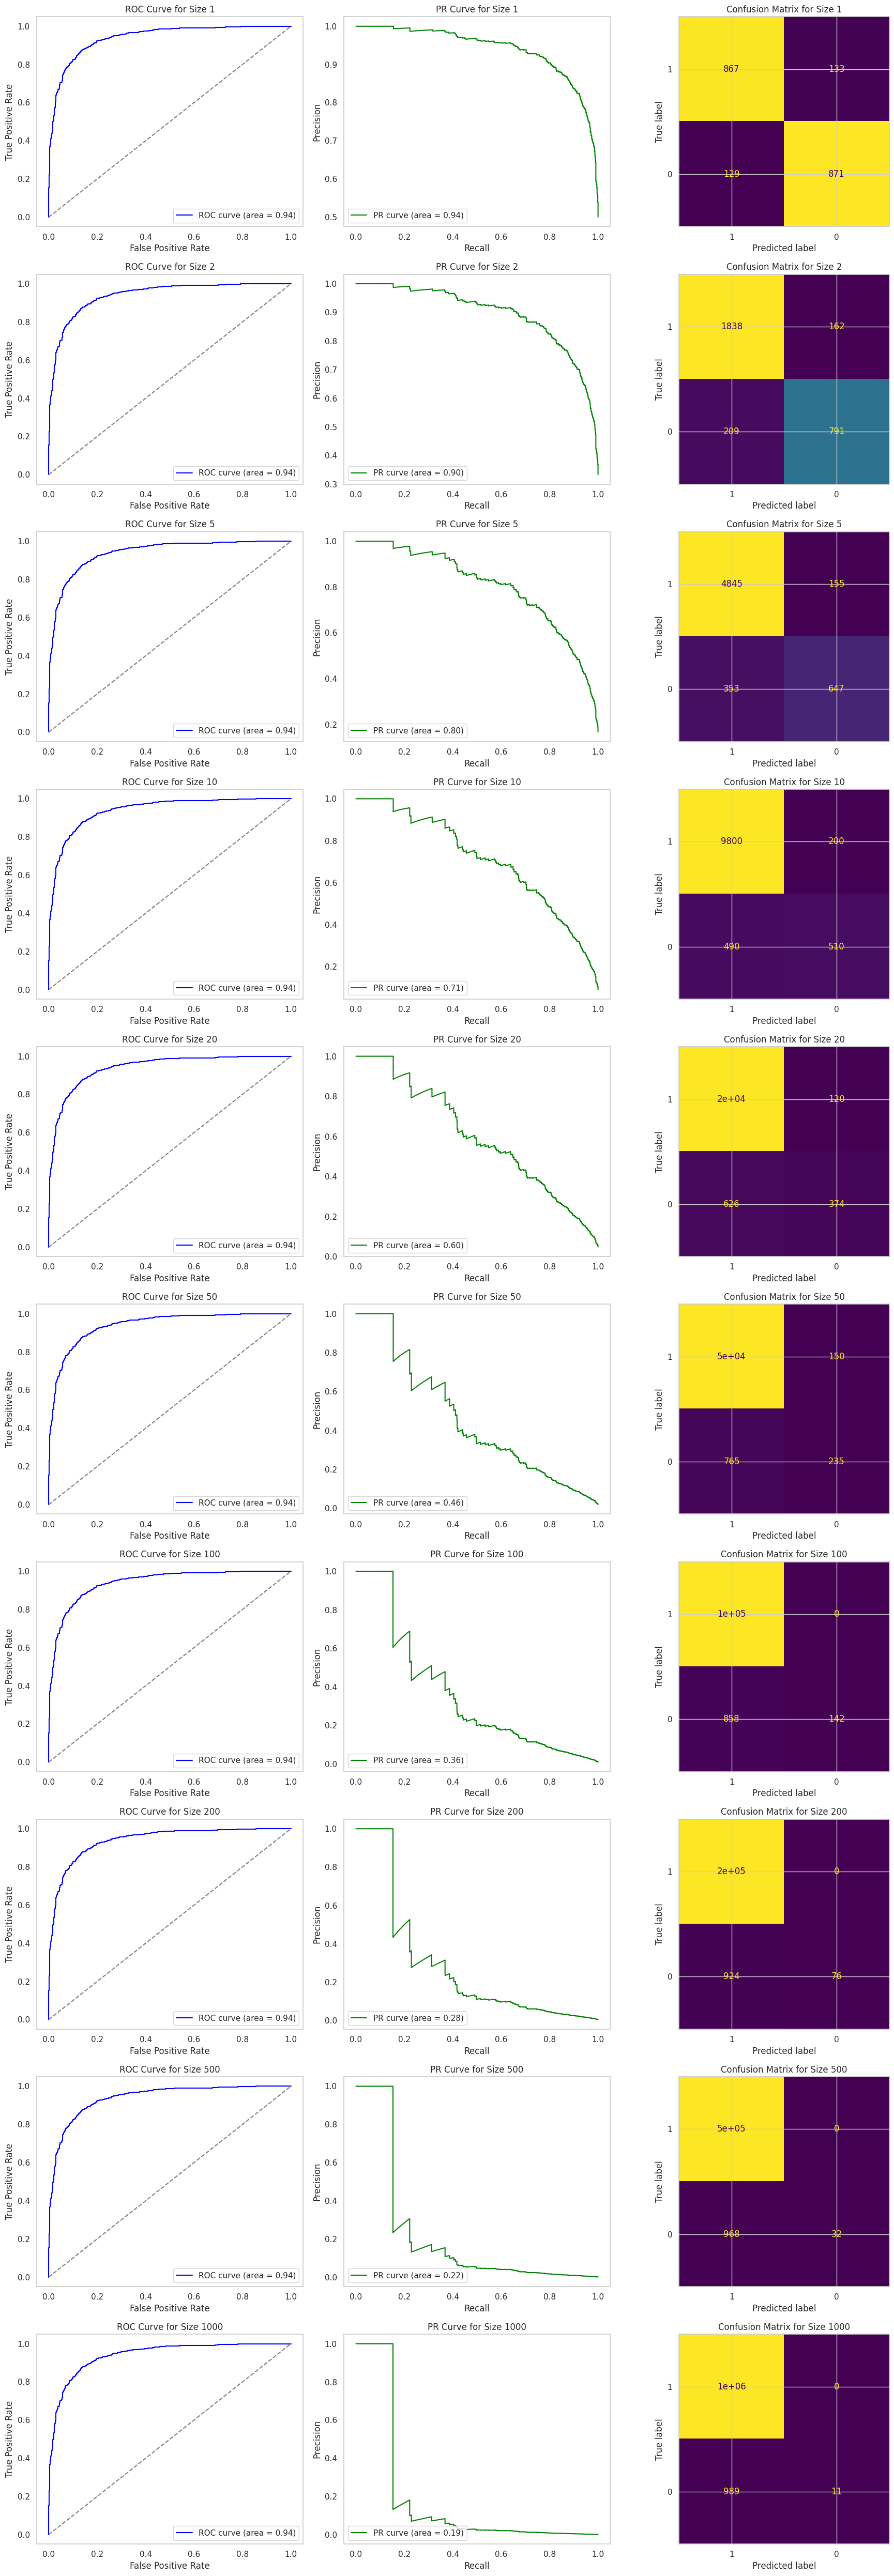

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(len(sizes), 3, figsize=(18, 5 * len(sizes)))
axes = axes.flatten()

results = []

for i, size in enumerate(sizes):
    df_temp = duplicate_class(df, cls_name=1, n=size)  
    df_temp = df_temp[df_temp['class'].isin([1, 2])] 
    lda = LDA(n_components=1)

    X = df_temp[['feature_3', 'feature_4']]
    y = df_temp['class']
    y = y.replace(1, 0)
    y = y.replace(2, 1)
    lda.fit(X, y)

    y_scores = lda.predict_proba(X)[:, 1]
    y_pred = lda.predict(X)

    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    axes[i * 3].plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
    axes[i * 3].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i * 3].set_xlabel('False Positive Rate')
    axes[i * 3].set_ylabel('True Positive Rate')
    axes[i * 3].set_title(f'ROC Curve for Size {size}')
    axes[i * 3].legend(loc='lower right')
    axes[i * 3].grid()

    precision, recall, _ = precision_recall_curve(y, y_scores)
    auprc = auc(recall, precision)

    axes[i * 3 + 1].plot(recall, precision, color='green', label='PR curve (area = {:.2f})'.format(auprc))
    axes[i * 3 + 1].set_xlabel('Recall')
    axes[i * 3 + 1].set_ylabel('Precision')
    axes[i * 3 + 1].set_title(f'PR Curve for Size {size}')
    axes[i * 3 + 1].legend(loc='lower left')
    axes[i * 3 + 1].grid()

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0]) 
    disp.plot(ax=axes[i * 3 + 2], colorbar=False)
    axes[i * 3 + 2].set_title(f'Confusion Matrix for Size {size}')

    results.append({'size': size, 'AUROC': roc_auc, 'AUPRC': auprc})

plt.tight_layout()
plt.show()


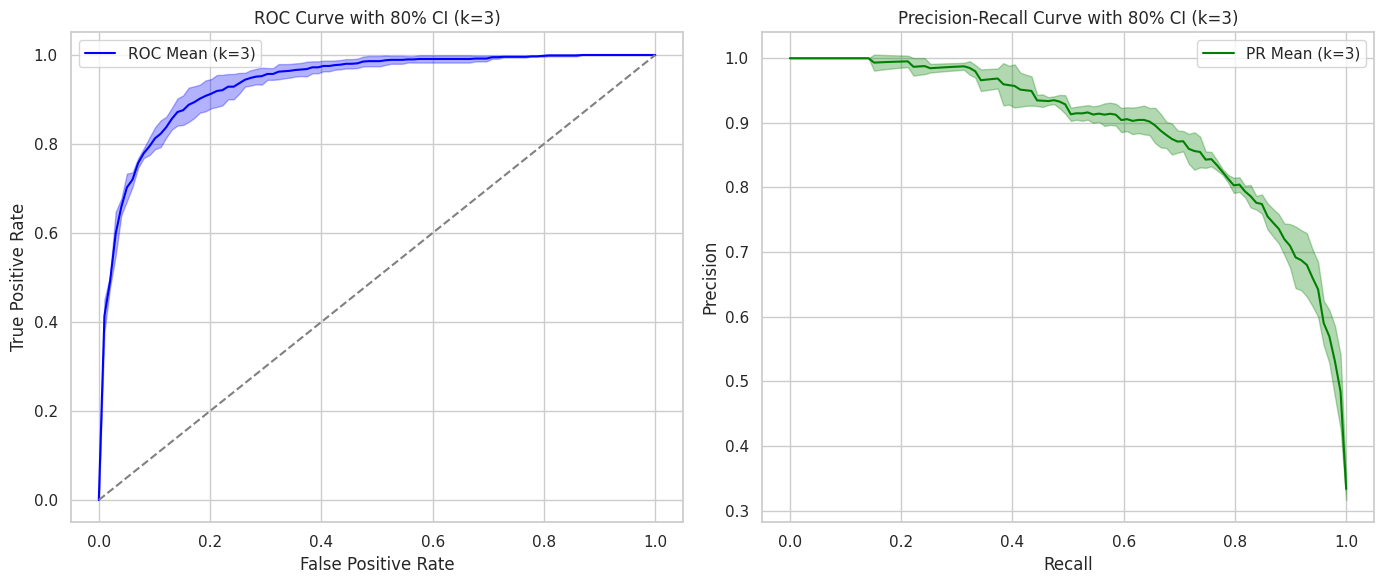

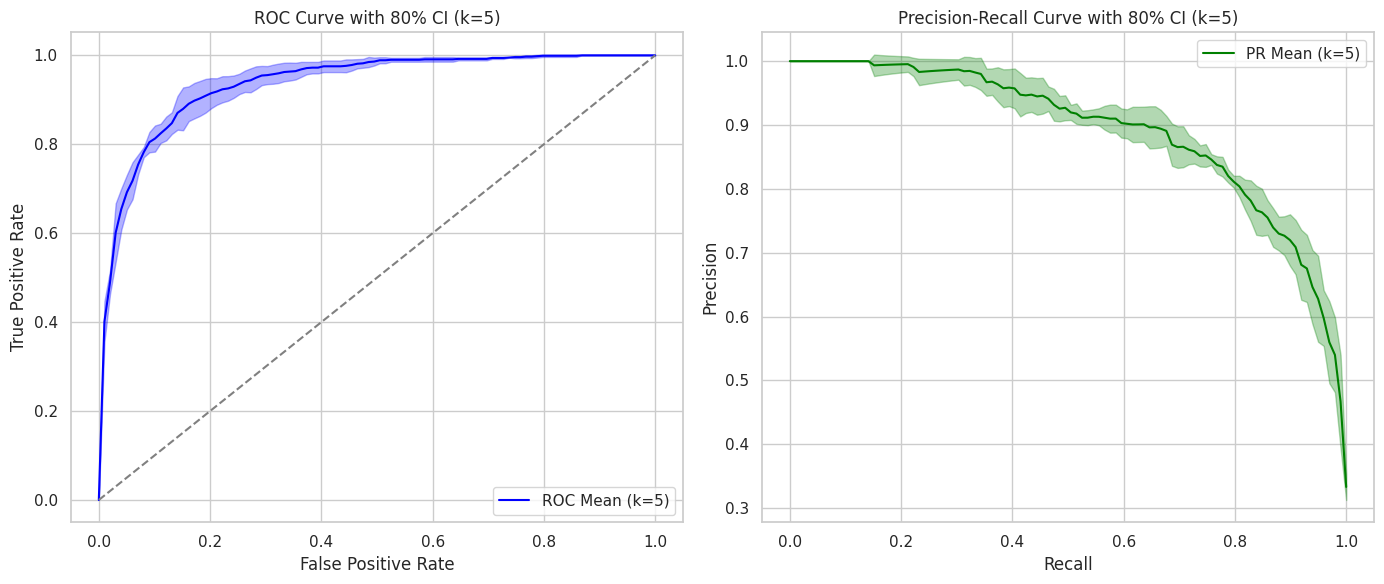

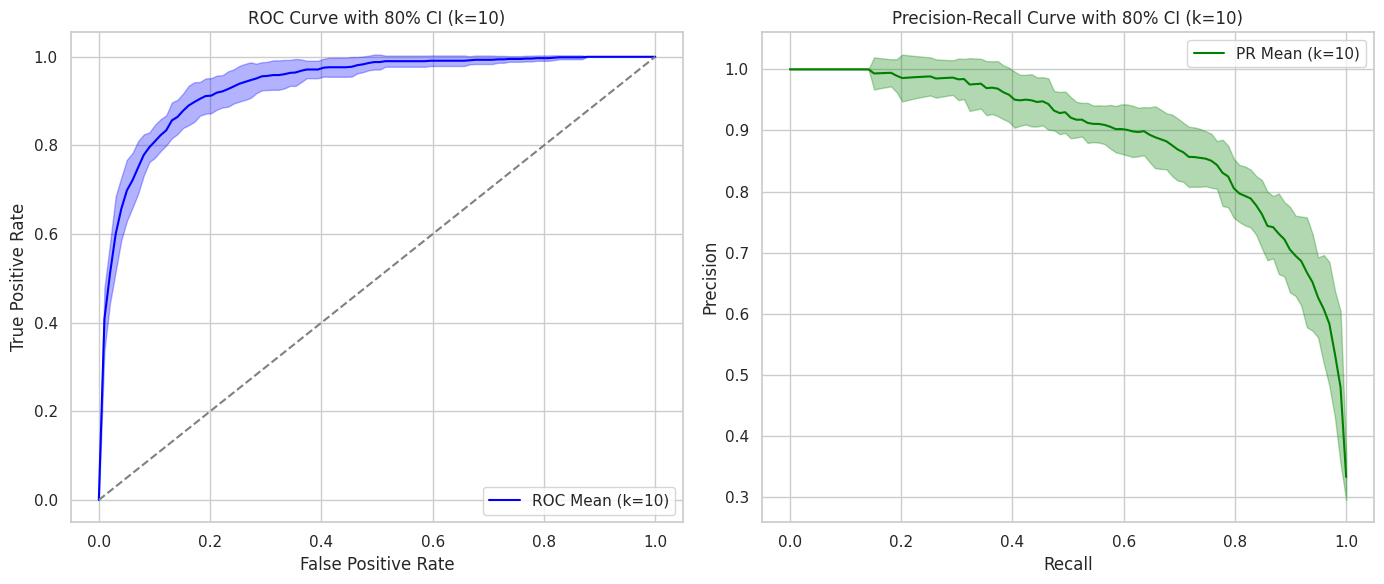

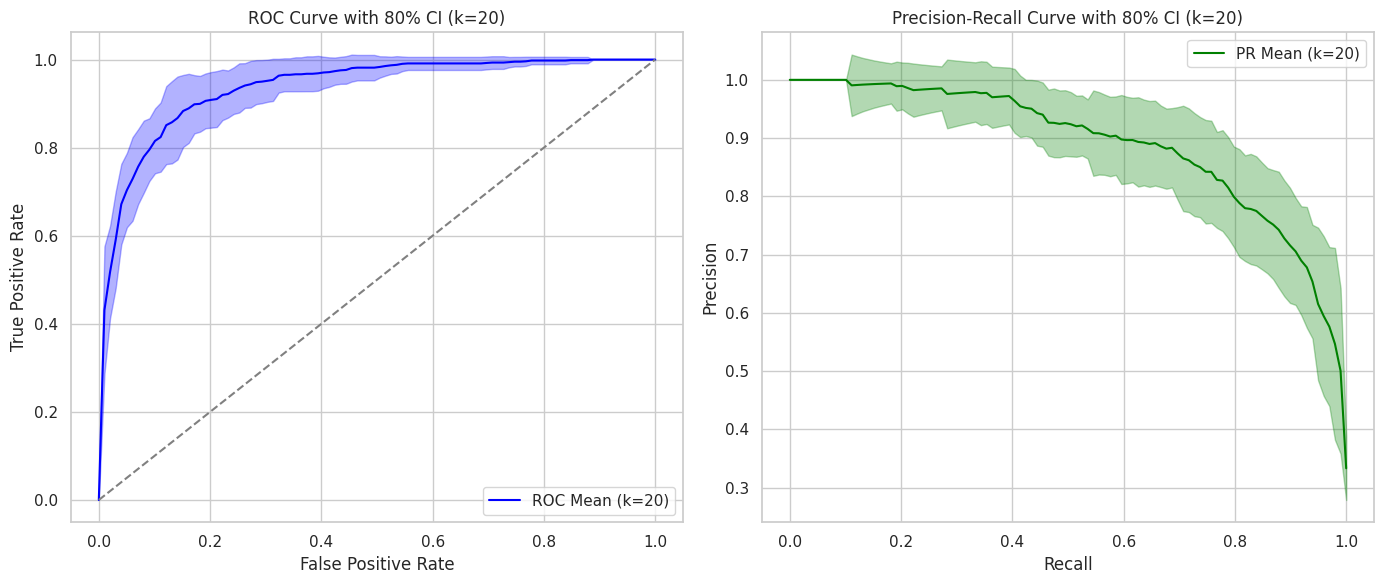

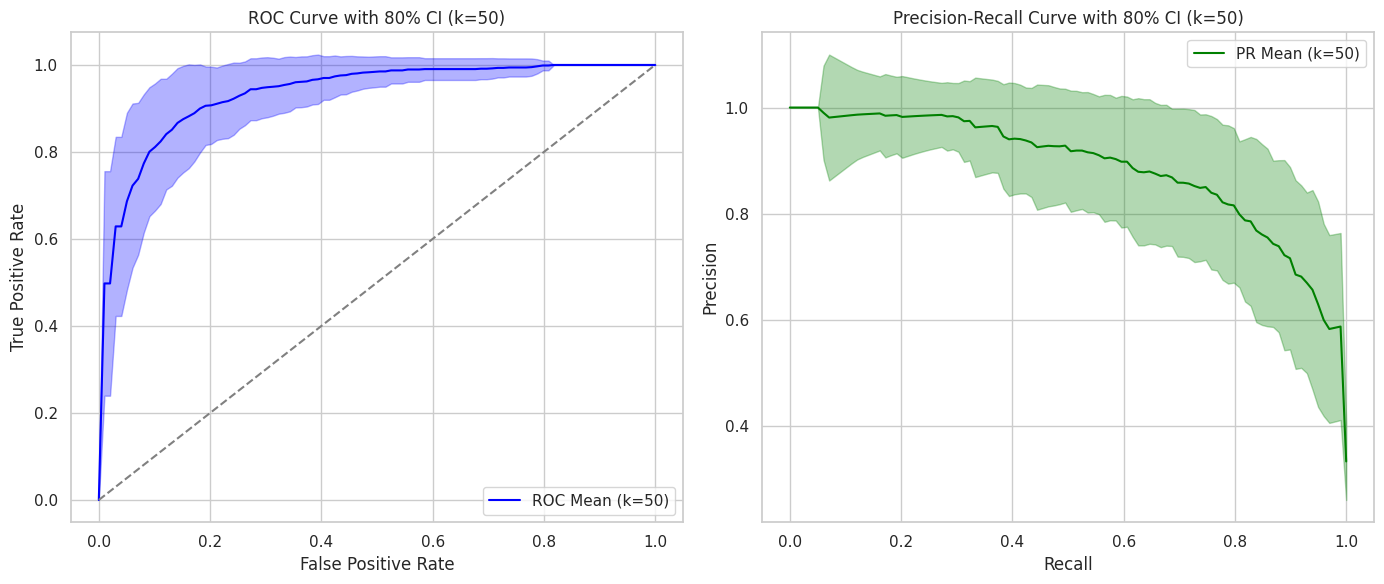

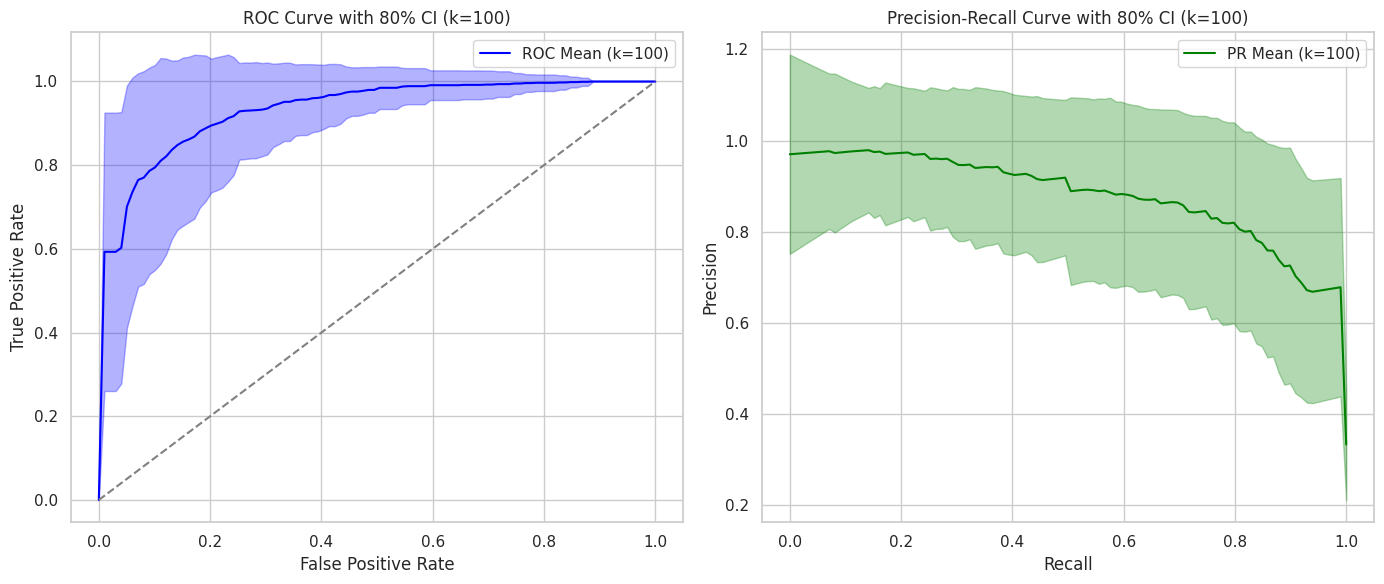

In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from scipy import stats

def plot_confidence_interval_curve(mean_curve, std_curve, x_range, label, color, ci=95):
    ci_factor = stats.norm.ppf(1 - (1 - ci / 100) / 2)
    lower_bound = mean_curve - ci_factor * std_curve
    upper_bound = mean_curve + ci_factor * std_curve
    plt.fill_between(x_range, lower_bound, upper_bound, color=color, alpha=0.3, label=f'{label} CI {ci}%')
    plt.plot(x_range, mean_curve, color=color, label=f'{label} Mean')

def compute_roc_pr_curves(X, y, kf):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    prs = []
    mean_recall = np.linspace(0, 1, 100)
    
    roc_aucs = []
    pr_aucs = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LDA(n_components=1)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        prs.append(np.interp(mean_recall, recall[::-1], precision[::-1])) 
        pr_auc = average_precision_score(y_test, y_pred_proba)
        pr_aucs.append(pr_auc)

    return np.array(tprs), np.array(prs), mean_fpr, mean_recall, np.array(roc_aucs), np.array(pr_aucs)

def plot_roc_pr_curves_with_ci(X, y, fold_values, ci=95):
    for k in fold_values:
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        tprs, prs, mean_fpr, mean_recall, roc_aucs, pr_aucs = compute_roc_pr_curves(X, y, kf)

        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0
        axs[0].fill_between(mean_fpr, mean_tpr - stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_tpr, 
                            mean_tpr + stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_tpr, color='blue', alpha=0.3)
        axs[0].plot(mean_fpr, mean_tpr, color='blue', label=f'ROC Mean (k={k})')
        axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].set_title(f'ROC Curve with {ci}% CI (k={k})')
        axs[0].legend()

        mean_pr = np.mean(prs, axis=0)
        std_pr = np.std(prs, axis=0)
        axs[1].fill_between(mean_recall, mean_pr - stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_pr, 
                            mean_pr + stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_pr, color='green', alpha=0.3)
        axs[1].plot(mean_recall, mean_pr, color='green', label=f'PR Mean (k={k})')
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title(f'Precision-Recall Curve with {ci}% CI (k={k})')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

df_temp = duplicate_class(df, cls_name=1, n=1000)
df_temp = df_temp[df_temp['class'].isin([1, 2])]
X = df_temp[['feature_3', 'feature_4']]
y = df_temp['class']
y = y.replace(1, 0)
y = y.replace(2, 1)

fold_values = [3, 5, 10, 20, 50, 100]

plot_roc_pr_curves_with_ci(X, y, fold_values, ci=80)
